In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [2]:
soil_df = pd.read_csv(r'../data/output_csv_files/soil_df.csv', parse_dates = True)
# not specifying that the frequency is on a monthly basis led to errors while fitting models

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_period.html

In [3]:
# fitting model gave error that frequency was not set
soil_df.index = soil_df.index.to_period('M')

In [4]:
soil_df.isna().sum()

soil_moisture    0
dtype: int64

In [5]:
soil_df.index

PeriodIndex(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10',
             ...
             '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
             '2022-09', '2022-10', '2022-11', '2022-12'],
            dtype='period[M]', length=780)

There are 65 years in the dataset. A train/test split of .8 means that the first 52 years will be the train set, and the remaining 13 years will be the test set

In [6]:
print(f"Final year of train set: {1958 + (65*.8)}")

Final year of train set: 2010.0


So, the train set will be `1958-Jan-01 to 2010-Dec-31` and the test set will be `2011-Jan-01` to `2022-Dec-01`

In [7]:
train_start = '1958-01'
train_end = '2010-01'

test_start = '2010-02'
test_end = '2022-01'

train = soil_df.loc[train_start:train_end]
test = soil_df.loc[test_start:test_end]

In [8]:
train.tail()

,soil_moisture
2009-09,21780.596266
2009-10,21781.543976
2009-11,21781.704324
2009-12,21782.148820
2010-01,21782.363567


In [9]:
test.head()

,soil_moisture
2010-02,21782.515428
2010-03,21782.434867
2010-04,21782.770233
2010-05,21782.404200
2010-06,21781.462729


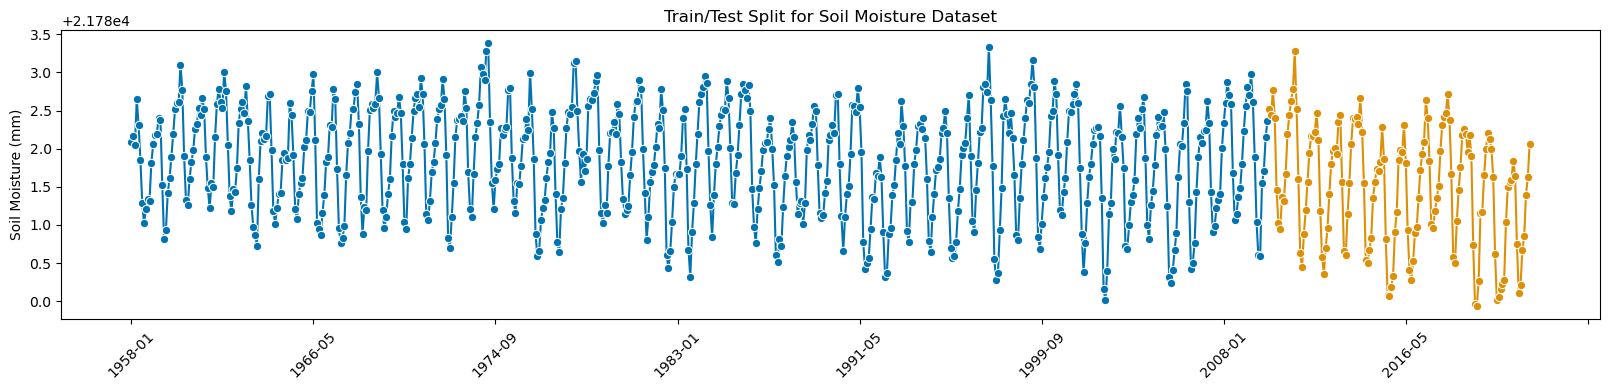

In [10]:
plot_series(train, test)
plt.xticks(rotation = 45);
plt.title('Train/Test Split for Soil Moisture Dataset');

plt.tight_layout()
plt.ylabel('Soil Moisture (mm)')
plt.savefig('../Data/output_csv_files/soil_moisture_overall.png')

Visually, the data appears to be fairly stationary, although there may be a slight downward tend. How to check for stationality:</br>
https://machinelearningmastery.com/time-series-data-stationary-python/

In [11]:
# via above site
X = soil_df.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.441184
p-value: 0.009633
	1%: -3.439
	5%: -2.865
	10%: -2.569


The ADF statistic here is essentially the same as the critical score for the 1% confidence interval, indicating that there's esentially no trend within soil moisture over time. That said, there visually appears to be a downward trend towards the end of the dataset.

***SARIMA MODEL***

The seasonality is pretty clearly on a yearly basis, so I'll use `sp = 12`, since the index frequency has been set to monthly.

C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


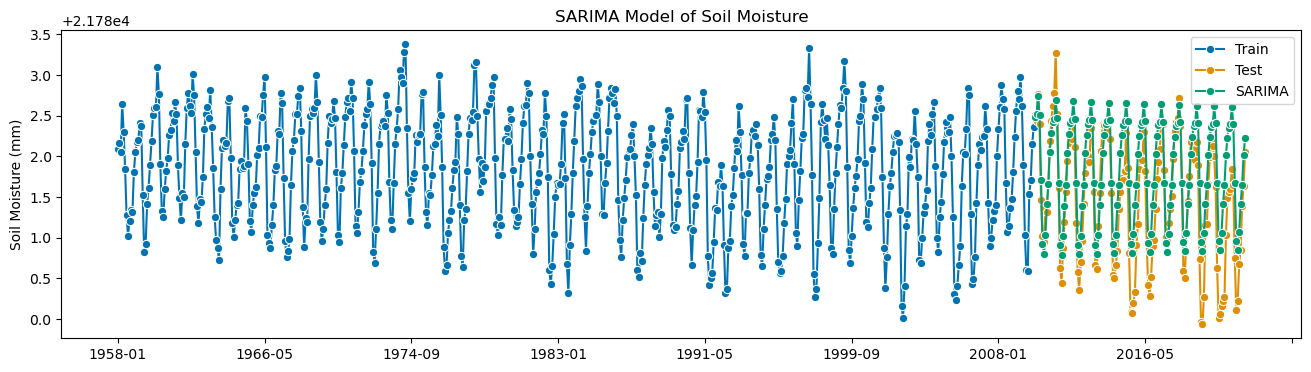

In [12]:
# via lesson 9.03 Time Series Forecasting Intro
sarima_model = AutoARIMA(sp = 12, maxiter = 1000)
sarima_model.fit(train)

sarima_preds = sarima_model.predict(test.index)
plot_series(train, test, sarima_preds,
           labels = ['Train', 'Test', 'SARIMA'])
plt.ylabel('Soil Moisture (mm)')
plt.title('SARIMA Model of Soil Moisture');

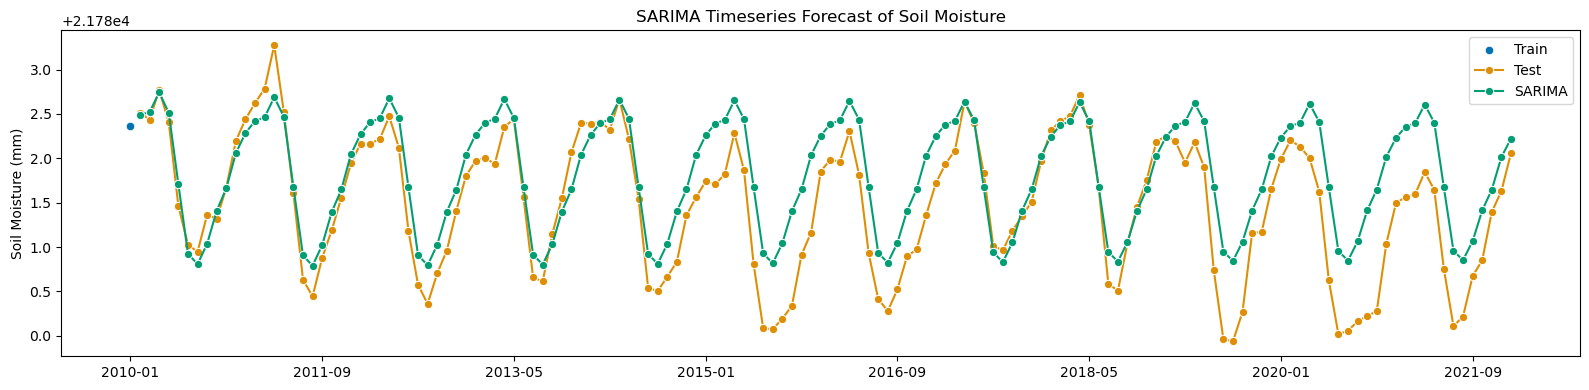

In [13]:
# modified via lesson 9.03 Time Series Forecasting Intro
sarima_preds = sarima_model.predict(test.index)
plot_series(train.loc['2010-01-01':], test.loc['2010-01-01':], sarima_preds.loc['2010-01-01':],
           labels = ['Train', 'Test', 'SARIMA'])
plt.title('SARIMA Timeseries Forecast of Soil Moisture');
plt.ylabel('Soil Moisture (mm)')

plt.tight_layout()
plt.savefig('../Data/output_csv_files/sarima_overall.png')

Visually, this apppears to be a fairly strong model, although it does diverge pretty significantly as time goes on.

In [14]:
print(f"SARIMA MSE score: {mean_squared_error(test, sarima_preds).round(4)}")
print(f"SARIMA R2 score: {r2_score(test, sarima_preds).round(4)}")

SARIMA MSE score: 0.2405
SARIMA R2 score: 0.5992


Looking at the MSE and R2 though, this model doesn't appear to be all that great. That said, this is a timeseries forecast model and it's only using a single feature, so an R2 of .6 doesn't strike me as horrible either.

***Holt-Winters Model: 'None' Trend Specified***

In [15]:
# via lesson 9.03 Time Series Forecasting Intro
hw = ExponentialSmoothing(train,
                     trend = None,
                    # adding on the 12-month seasonality
                      seasonal = 'add',
                      seasonal_periods = 12).fit()

hw_preds = hw.forecast(len(test))

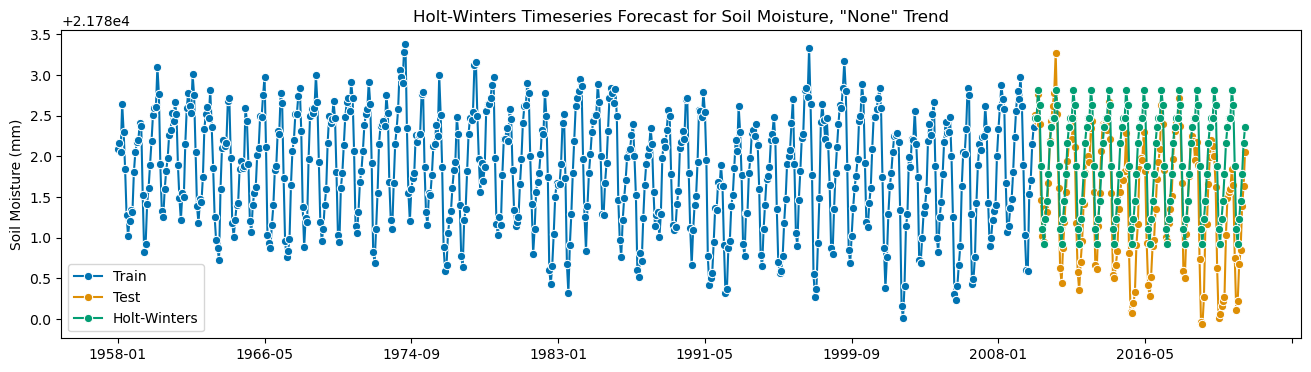

In [16]:
# via lesson 9.03 Time Series Forecasting Intro
plot_series(train, test, hw_preds,
           labels = ['Train', 'Test', 'Holt-Winters']);
plt.ylabel('Soil Moisture (mm)')
plt.title('Holt-Winters Timeseries Forecast for Soil Moisture, "None" Trend');

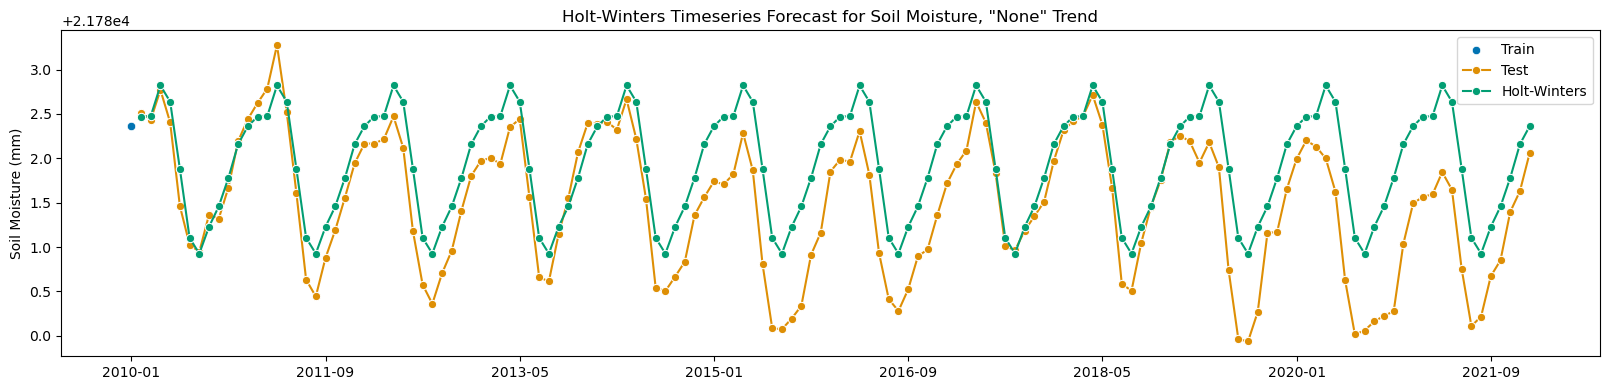

In [17]:
# via lesson 9.03 Time Series Forecasting Intro
plot_series(train.loc['2010-01-01':], test.loc['2010-01-01':], hw_preds.loc['2010-01-01':],
           labels = ['Train', 'Test', 'Holt-Winters']);
plt.title('Holt-Winters Timeseries Forecast for Soil Moisture, "None" Trend');
plt.tight_layout()
plt.ylabel('Soil Moisture (mm)')
plt.savefig('../Data/output_csv_files/hw_overall.png')

In [18]:
print(f"Holt-Winters MSE score: {mean_squared_error(test, hw_preds).round(4)}")
print(f"Holt-Winters R2 score: {r2_score(test, hw_preds).round(4)}")

Holt-Winters MSE score: 0.3504
Holt-Winters R2 score: 0.4161


This Holt-Winters model is actually performing worse than SARIMA.

***Holt-Winters Model: 'Add' Trend Specified***

Since there is a minor amount of downward trend in soil moisture, I'll try setting `trend` to 'add':

In [19]:
# via lesson 9.03 Time Series Forecasting Intro
hw = ExponentialSmoothing(train,
                     trend = 'add',
                    # adding on the 12-month seasonality
                      seasonal = 'add',
                      seasonal_periods = 12).fit()

hw_preds = hw.forecast(len(test))

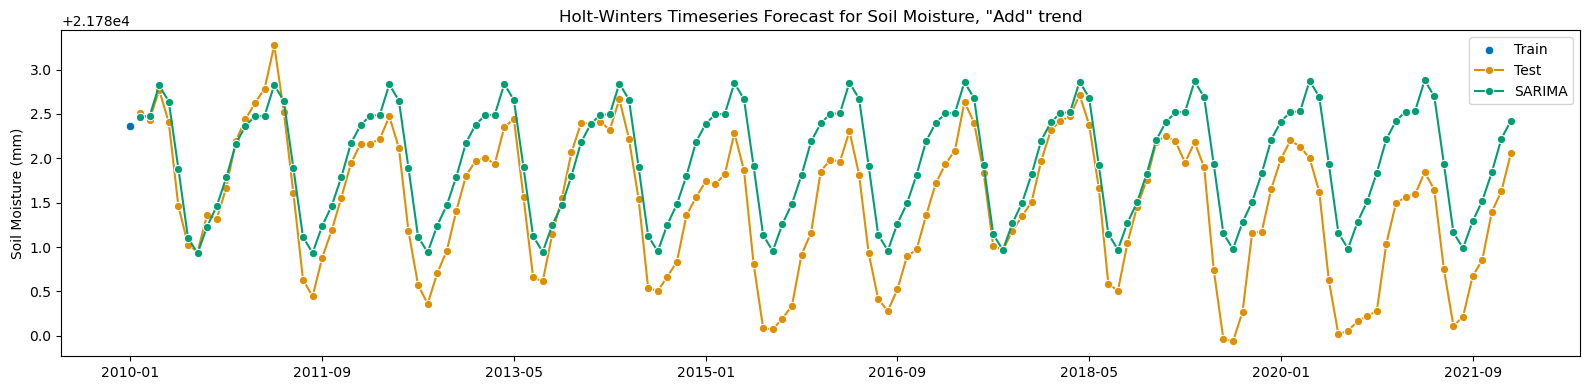

In [20]:
plot_series(train.loc['2010-01-01':], test.loc['2010-01-01':], hw_preds.loc['2010-01-01':],
           labels = ['Train', 'Test', 'SARIMA']);
plt.title('Holt-Winters Timeseries Forecast for Soil Moisture, "Add" trend');
plt.ylabel('Soil Moisture (mm)')
plt.tight_layout()
plt.savefig('../Data/output_csv_files/hw_add_overall.png')

In [21]:
print(f"Holt-Winters MSE score: {mean_squared_error(test, hw_preds).round(4)}")
print(f"Holt-Winters R2 score: {r2_score(test, hw_preds).round(4)}")

Holt-Winters MSE score: 0.3875
Holt-Winters R2 score: 0.3543


Even though a negative trend was noticed in the data, setting `trend` to add surprisingly caused the R2 to decrease pretty significantly - the MSE increased as well. As noted, the trend is fairly minor, so perhaps it was overcompensating.

***2010-2023 SARIMA Model:***

The first time I modeled this data, I did so using only soil moisture from 2010-2023, and I remember the SARIMA model performing well. I'll see if my memory is correct:

In [22]:
train_start = '2010-01-01'
train_end = '2019-06-30'

test_start = '2019-07-01'
test_end = '2022-12-01'

train_2010 = soil_df.loc[train_start:train_end]
test_2010 = soil_df.loc[test_start:test_end]

Text(0.5, 1.0, 'Train/Test for 2010-2023 Soil Moisture Data')

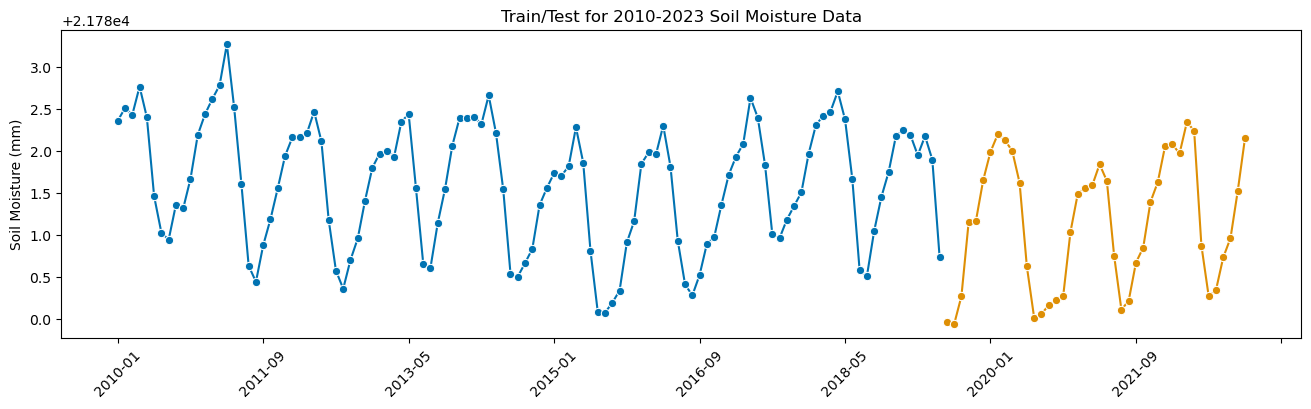

In [23]:
plot_series(train_2010, test_2010)
plt.xticks(rotation = 45);
plt.ylabel('Soil Moisture (mm)')
plt.title('Train/Test for 2010-2023 Soil Moisture Data')

C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

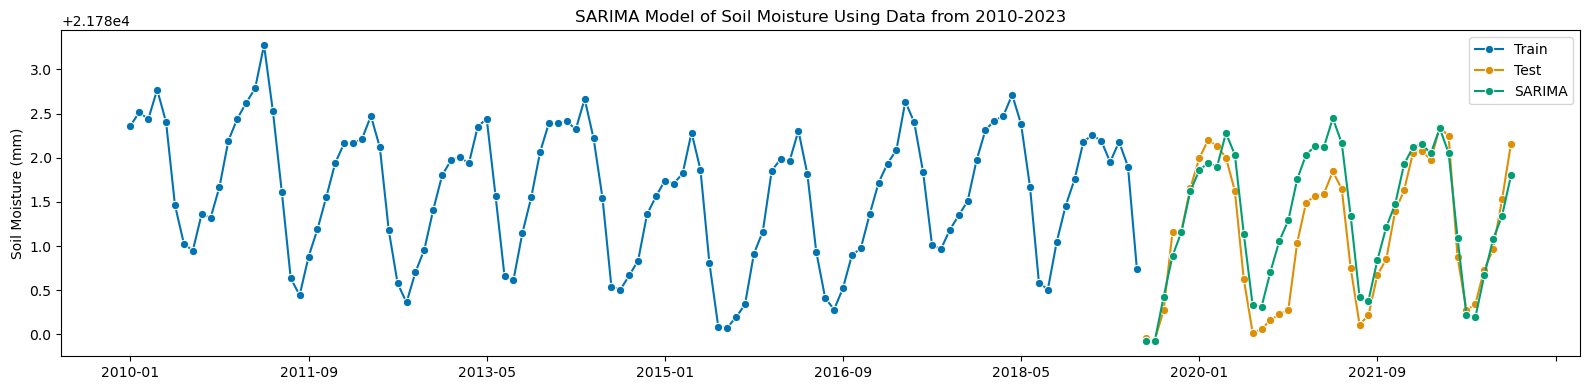

In [24]:
# via lesson 9.03 Time Series Forecasting Intro
sarima_model_2010 = AutoARIMA(sp = 12, maxiter = 1000)
sarima_model_2010.fit(train_2010)

sarima_preds_2010 = sarima_model_2010.predict(test_2010.index)
plot_series(train_2010, test_2010, sarima_preds_2010,
           labels = ['Train', 'Test', 'SARIMA'])
plt.ylabel('Soil Moisture (mm)')
plt.title('SARIMA Model of Soil Moisture Using Data from 2010-2023');
plt.tight_layout()
plt.savefig('../Data/output_csv_files/sarima_2010.png')

In [33]:
print(f"SARIMA MSE score: {mean_squared_error(test_2010, sarima_preds_2010).round(4)}")
print(f"SARIMA RMSE score: {mean_squared_error(test_2010, sarima_preds_2010, squared = False).round(4)}")
print(f"SARIMA R2 score: {r2_score(test_2010, sarima_preds_2010).round(4)}")

SARIMA MSE score: 0.1429
SARIMA RMSE score: 0.378
SARIMA R2 score: 0.7579


Surprisingly yes, the model using only data from 2010 to 2023 is actually performing the best so far. It's not even close, actually. Part of the issue may be that the model is testing on a relatively small amount of data, so I would'nt nescecarily trust this result.

***Conclusions:***

Although not immediately obvious at first, there are actually two very different trends present in this soil moisture data

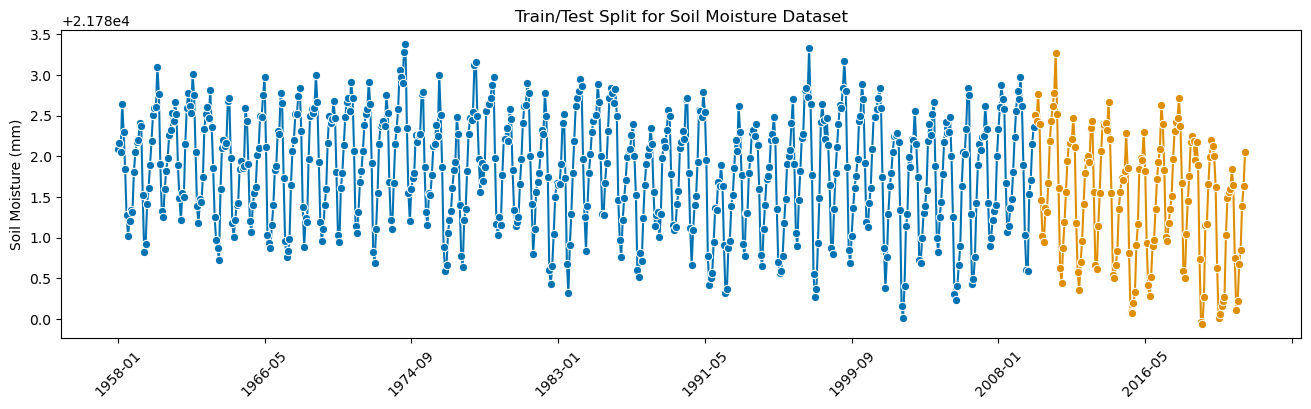

In [26]:
plot_series(train, test)
plt.xticks(rotation = 45);
plt.ylabel('Soil Moisture (mm)')
plt.title('Train/Test Split for Soil Moisture Dataset');

In the first era, ~1958-2010, the trend is roughly flat. There is overall no major trend in soil moisture, even if extreme highs and lows do become a bit more common.

In [27]:
# https://machinelearningmastery.com/time-series-data-stationary-python/
X = soil_df.loc[:'2010'].values
X = log(X)
result = adfuller(X)
print('ADF Test for Soil Moisture 1958-2010')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Test for Soil Moisture 1958-2010
ADF Statistic: -4.814659
p-value: 0.000051
	1%: -3.441
	5%: -2.866
	10%: -2.569


The ADF statistic is far below the critical score for the highest confidence interval (1%). This means it's highly likely that the data has no trend for the first era (1958-2010), which is clear from the plot as well.

In the second era, ~2010 onward, the soil moisture takes a sharp downward trajectory. Ironically, this is also the point where the train/test split takes place. For this reason, the models analyzing the previous era's data performed quite poorly.

My model of data for data from 2010-2023 performed much better for this reason.

In [28]:
# https://machinelearningmastery.com/time-series-data-stationary-python/
X = soil_df.loc['2010':].values
X = log(X)
result = adfuller(X)
print('ADF Test for Soil Moisture 1958-2010')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Test for Soil Moisture 1958-2010
ADF Statistic: -2.680963
p-value: 0.077391
	1%: -3.477
	5%: -2.882
	10%: -2.578


The critical score for the 1% confidence interval is far below the ADF score, meaning it is highly likely that there is a downward trend. Again, this is shown clearly by the plot. This indicates a fundamental break between these two eras in the long-term trend of soil moisture. 

The primary conclusion here is that _soil moisture data from 1958-2010 cannot reliably be used to forecast soil moisture after this era_ due to there being a dramatic change in the long-term trajectory of this metric after this era.